## Patch Extraction 1 : Sliding Window

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tifffile as tiff
import cv2
import os
from tqdm import tqdm
import zipfile
import rasterio
from rasterio.windows import Window
from torch.utils.data import Dataset
import gc
import numpy as np
from glob import glob
path_common = '../'

In [5]:
sz = 512   #the size of tiles
window = 256 #the size of sliding window
reduce = 1 #reduce the original images by 4 times 
MASKS = 'mask/'
DATA = 'data/'

In [6]:
OUT_TRAIN = 'train.zip'
OUT_MASKS = 'masks.zip'

In [7]:
tiff_lst = glob(os.path.join(path_common, DATA, "*tiff"))

In [ ]:
data = rasterio.open(tiff_lst[0], num_threads='all_cpus')

In [ ]:
#use rasterio to load image part by part

s_th = 40  #saturation blancking threshold
p_th = 1000 #threshold for the minimum number of pixels


class IgANDataset(Dataset):
    def __init__(self, imgpath, maskpath, sz=sz, window=window, reduce=reduce):
        self.data = rasterio.open(imgpath ,num_threads='all_cpus')
        # some images have issues with their format 
        # and must be saved correctly before reading with rasterio
        if self.data.count != 3:
            subdatasets = self.data.subdatasets
            self.layers = []
            if len(subdatasets) > 0:
                for i, subdataset in enumerate(subdatasets, 0):
                    self.layers.append(rasterio.open(subdataset))
        self.shape = self.data.shape
        self.reduce = reduce
        self.sz = reduce*sz
        self.window = window
        self.n0max = (self.shape[0] - self.sz)//self.window + 2
        self.n1max = (self.shape[1] - self.sz)//self.window + 2
        self.mask = cv2.imread(maskpath, cv2.IMREAD_GRAYSCALE)
        
    def __len__(self):
        return self.n0max*self.n1max
    
    def __getitem__(self, idx):
        # the code below may be a little bit difficult to understand,
        # but the thing it does is mapping the original image to
        # tiles created with adding padding (like in the previous version of the kernel)
        # then the tiles are loaded with rasterio
        # n0,n1 - are the x and y index of the tile (idx = n0*self.n1max + n1)
        n0,n1 = idx//self.n1max, idx%self.n1max
        # x0,y0 - are the coordinates of the lower left corner of the tile in the image
        # negative numbers correspond to padding (which must not be loaded)
        x0,y0 = n0*self.window, n1*self.window

        # make sure that the region to read is within the image
        p00,p01 = max(0,x0), min(x0+self.sz,self.shape[0])
        p10,p11 = max(0,y0), min(y0+self.sz,self.shape[1])
        img = np.zeros((self.sz,self.sz,3),np.uint8)
        mask = np.zeros((self.sz,self.sz),np.uint8)
        # mapping the loade region to the tile
        if self.data.count == 3:
            img[(p00-x0):(p01-x0),(p10-y0):(p11-y0)] = np.moveaxis(self.data.read([1,2,3],
                window=Window.from_slices((p00,p01),(p10,p11))), 0, -1)
        else:
            for i,layer in enumerate(self.layers):
                img[(p00-x0):(p01-x0),(p10-y0):(p11-y0),i] =\
                  layer.read(1,window=Window.from_slices((p00,p01),(p10,p11)))
        if self.mask is not None: mask[(p00-x0):(p01-x0),(p10-y0):(p11-y0)] = self.mask[p00:p01,p10:p11]
        
        if self.reduce != 1:
            img = cv2.resize(img,(self.sz//reduce,self.sz//reduce),
                             interpolation = cv2.INTER_AREA)
            mask = cv2.resize(mask,(self.sz//reduce,self.sz//reduce),
                             interpolation = cv2.INTER_NEAREST)
        #check for empty imges
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h,s,v = cv2.split(hsv)
        #return -1 for empty images
        return img, mask, (-1 if (s>s_th).sum() <= p_th or img.sum() <= p_th else idx)

In [ ]:
x_tot,x2_tot = [],[]
with zipfile.ZipFile(OUT_TRAIN, 'w') as img_out,\
 zipfile.ZipFile(OUT_MASKS, 'w') as mask_out:
    for tiff in tqdm(tiff_lst):
        #image+mask dataset
        ds = IgANDataset(tiff, '../mask/S 050026746_8_PAS_mask.tiff')
        for i in range(len(ds)):
            im,m,idx = ds[i]
            if idx < 0: continue
                
            x_tot.append((im/255.0).reshape(-1,3).mean(0))
            x2_tot.append(((im/255.0)**2).reshape(-1,3).mean(0))
            
            #write data   
            im = cv2.imencode('.png',cv2.cvtColor(im, cv2.COLOR_RGB2BGR))[1]
            img_out.writestr(f"{tiff.split('/')[-1].split('.')[0]}_{idx:04d}.png", im)
            m = cv2.imencode('.png',m)[1]
            mask_out.writestr(f"{tiff.split('/')[-1].split('.')[0]}_{idx:04d}.png", m)
        
#image stats
img_avr =  np.array(x_tot).mean(0)
img_std =  np.sqrt(np.array(x2_tot).mean(0) - img_avr**2)
print('mean:',img_avr, ', std:', img_std)

In [ ]:
columns, rows = 4,4
idx0 = 140
fig=plt.figure(figsize=(columns*4, rows*4))
with zipfile.ZipFile(OUT_TRAIN, 'r') as img_arch, \
     zipfile.ZipFile(OUT_MASKS, 'r') as msk_arch:
    fnames = sorted(img_arch.namelist())[8:]
    for i in range(rows):
        for j in range(columns):
            idx = i+j*columns
            img = cv2.imdecode(np.frombuffer(img_arch.read(fnames[idx0+idx]), 
                                             np.uint8), cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            mask = cv2.imdecode(np.frombuffer(msk_arch.read(fnames[idx0+idx]), 
                                              np.uint8), cv2.IMREAD_GRAYSCALE)
    
            fig.add_subplot(rows, columns, idx+1)
            plt.axis('off')
            plt.imshow(Image.fromarray(img))
            plt.imshow(Image.fromarray(mask), alpha=0.2)
plt.show()

## Patch Extraction 2 : Use glom label.csv

In [2]:
df = pd.read_csv(os.path.join(path_common, "mask/test.csv"))

In [3]:
df

,filename,layer,cnt,rmost,bmost,lmost,tmost
0,S 050026746_8_PAS.svs,1,"[(20571, 923), (20567, 925), (20562, 927), (20...",20621,937,20487,834
1,S 050026746_8_PAS.svs,1,"[(21575, 7165), (21582, 7162), (21589, 7159), ...",21619,7176,21451,6894
2,S 050026746_8_PAS.svs,1,"[(21236, 8250), (21232, 8249), (21228, 8248), ...",21275,8390,21158,8246
3,S 050026746_8_PAS.svs,1,"[(21321, 9090), (21323, 9088), (21326, 9084), ...",21370,9104,21174,8889
4,S 050026746_8_PAS.svs,2,"[(21018, 7092), (21021, 7089), (21023, 7086), ...",21028,7116,20922,6993
5,S 050026746_8_PAS.svs,2,"[(21329, 9588), (21325, 9588), (21321, 9587), ...",21339,9693,21240,9585
6,S 050026746_8_PAS.svs,4,"[(21035, 7696), (21036, 7701), (21036, 7707), ...",21037,7763,20855,7539
7,S 050026746_8_PAS.svs,4,"[(21259, 9233), (21259, 9235), (21259, 9238), ...",21262,9306,21091,9141


original image shape (9883, 2156, 3)


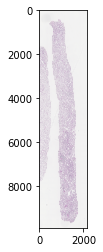

In [8]:
baseimage = tiff.imread(tiff_lst[0])
print ('original image shape',baseimage.shape)
baseimage = np.squeeze(baseimage)
if( baseimage.shape[0] == 3):
    baseimage = baseimage.swapaxes(0,1)
    baseimage = baseimage.swapaxes(1,2)
    print ('swaped shape',baseimage.shape)
plt.imshow(baseimage)

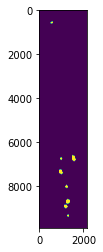

In [9]:
mask = tiff.imread('../mask/S 050026746_8_PAS_mask.tiff')
mask_shape = mask.shape
plt.imshow(mask)

## Glom

In [10]:
from copy import deepcopy

In [11]:
tile_size = 512
window_shift = 256
working_image_id = tiff_lst[0].split('/')[-1].split('.')[0]

In [12]:
df_workingimg = df[df.filename == "S 050026746_8_PAS.svs"]
df_workingimg = df_workingimg.reset_index(drop=True)
lstart = np.array(df_workingimg.lmost).min()
tstart = np.array(df_workingimg.tmost).min()

df_workingimg.lmost = df_workingimg.lmost - lstart + 512
df_workingimg.rmost = df_workingimg.rmost - lstart + 512
df_workingimg.tmost = df_workingimg.tmost - tstart + 512
df_workingimg.bmost = df_workingimg.bmost - tstart + 512

In [13]:
def show_tile_and_mask(baseimage, mask, tile_size, tile_col_pos, tile_row_pos):
    start_col = tile_col_pos
    end_col = start_col + tile_size
    start_row = tile_row_pos
    end_row = start_row + tile_size
#     tile_image = baseimage[start_col:end_col, start_row:end_row,:]
    tile_mask = mask[start_col:end_col, start_row:end_row]
#     fig, ax = plt.subplots(1,2,figsize=(20,3))
#     ax[0].imshow(tile_image)
#     ax[1].imshow(tile_mask)
    return(tile_mask)

def extract_patch(baseimage, mask, tile_size, tile_col_pos, tile_row_pos, working_image_id, k, i):
    start_col = tile_col_pos
    end_col = start_col + tile_size
    start_row = tile_row_pos
    end_row = start_row + tile_size
    tile_image = baseimage[start_col:end_col, start_row:end_row,:]
    tile_mask = mask[start_col:end_col, start_row:end_row]
    tile_image = Image.fromarray(tile_image)
    tile_mask = Image.fromarray(tile_mask)
    tile_image.resize((256, 256)).save(f'../patches/tiles_r8_s256/{working_image_id}_{k}_{i}_glom.png')
    tile_mask.resize((256, 256)).save(f'../patches/masks_r8_s256/{working_image_id}_{k}_{i}_glom.png')

In [14]:
window_list = [256, 128, 64, 32]

k_list = np.array(range(len(df_workingimg)))
for wid, window_shift in enumerate(window_list):
    non_valid = []
    print(f'##### ID={working_image_id}, WINDOW_SIZE={window_shift} ####')
    for k in k_list:
        glu_patchs = df_workingimg.iloc[k]
        pts = []
        cnt = 0
        edge = 0
#             print(k)
        for i in range(1, (glu_patchs.tmost - glu_patchs.bmost + tile_size)//window_shift):
            for j in range(1, (glu_patchs.lmost - glu_patchs.rmost + tile_size)//window_shift):
                if mask_shape[0] - glu_patchs.tmost-window_shift*i < tile_size:
                    continue 
                elif mask_shape[1] - glu_patchs.lmost-window_shift*j < tile_size:
                    continue
                elif glu_patchs.tmost-window_shift*i < 0:
                    continue
                elif glu_patchs.lmost-window_shift*j < 0:
                    continue
                cnt += 1
                a = show_tile_and_mask(baseimage, mask, tile_size, glu_patchs.tmost-window_shift*i, glu_patchs.lmost-window_shift*j)
                if (a[0] + a[-1] + a[:, 0] + a[:, -1]).sum() != 0:
                    edge += 1
                else:
                    pts.append([glu_patchs.tmost-window_shift*i, glu_patchs.lmost-window_shift*j])
        if cnt-edge == 0:
            non_valid.append(k)
        else:
            for idx, pt in enumerate(pts):
                if idx > 3:
                    continue
                else:
                    extract_patch(baseimage, mask, tile_size, pt[0], pt[1], working_image_id, k, wid*100+idx)

    print(f'non_valid={len(non_valid)}')
    k_list = deepcopy(non_valid)

##### ID=S 050026746_8_PAS, WINDOW_SIZE=256 ####
non_valid=8
##### ID=S 050026746_8_PAS, WINDOW_SIZE=128 ####
non_valid=4
##### ID=S 050026746_8_PAS, WINDOW_SIZE=64 ####
non_valid=0
##### ID=S 050026746_8_PAS, WINDOW_SIZE=32 ####
non_valid=0


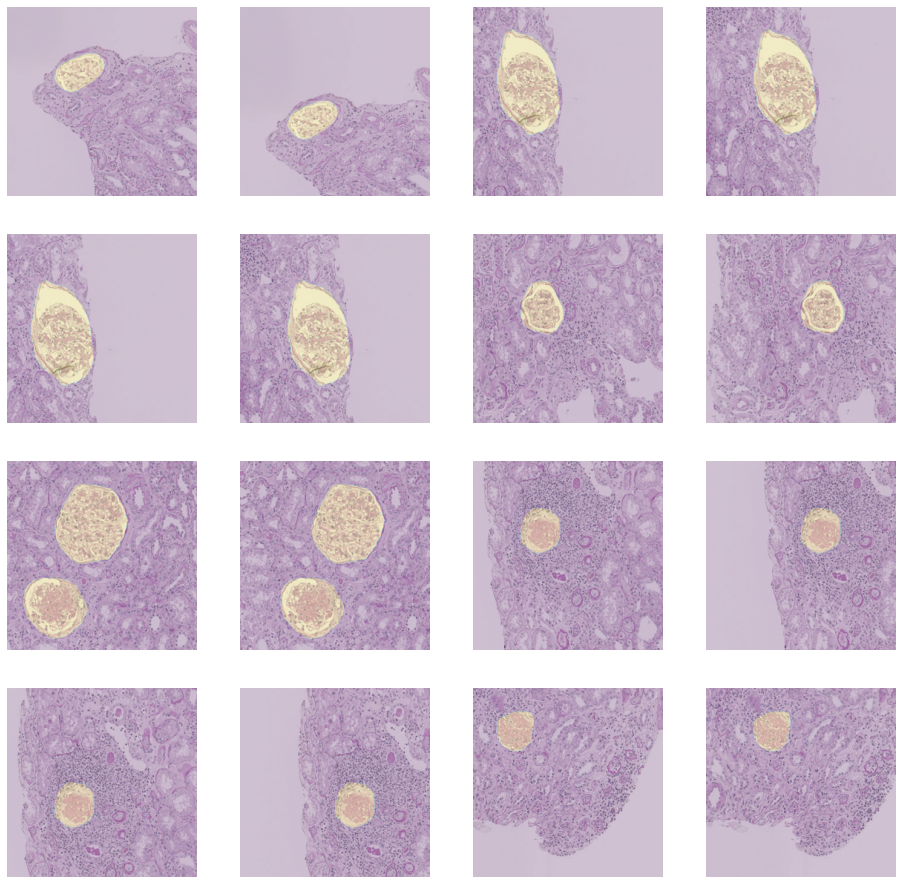

In [15]:
glom_lst = sorted(glob('../patches/tiles_r8_s256/*glom.png'))
mask_lst = sorted(glob('../patches/masks_r8_s256/*glom.png'))
columns, rows = 4,4
idx0 = 0
fig=plt.figure(figsize=(columns*4, rows*4))
for i in range(rows):
    for j in range(columns):
        idx = i+j*columns
        img = cv2.imread(glom_lst[idx0+idx], cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        mask = cv2.imread(mask_lst[idx0+idx], cv2.IMREAD_GRAYSCALE)

        fig.add_subplot(rows, columns, idx+1)
        plt.axis('off')
        plt.imshow(Image.fromarray(img))
        plt.imshow(Image.fromarray(mask), alpha=0.2)
plt.show()

## Foreground (no glom)

In [16]:
tile_size = 512
window_shift = 256
working_image_id = tiff_lst[0].split('/')[-1].split('.')[0]

In [17]:
pnts = []

for i in tqdm(range(mask_shape[0]//window_shift)):
    for j in range(mask_shape[1]//window_shift):
        tile_mask = mask[window_shift*i:window_shift*i+tile_size, window_shift*j:window_shift*j+tile_size]
        if tile_mask.sum() == 0:
            tile_image = baseimage[window_shift*i:window_shift*i+tile_size, window_shift*j:window_shift*j+tile_size,:]
#             img_hist = np.histogram(tile_image)
#             unique, counts = np.unique(tile_image, return_counts=True)
#             if np.asarray((unique, counts)).T[0][0] == 0 and np.asarray((unique, counts)).T[0][1] > 2000:
#                 continue
            hsv = cv2.cvtColor(tile_image, cv2.COLOR_RGB2HSV)
            h,s,v = cv2.split(hsv)
            if np.sum(s > 30) > 1000:
                tile_image = Image.fromarray(tile_image)
                mask_resized = Image.fromarray(tile_mask)
                tile_image.resize((256, 256)).save(f'../patches/tiles_r8_s256/{working_image_id}_{i}_{j}_no.png')
                mask_resized.resize((256, 256)).save(f'../patches/masks_r8_s256/{working_image_id}_{i}_{j}_no.png')
                pnts.append([window_shift*i, window_shift*j])

print(f'##### ID={working_image_id}, NUM_PATCH={len(pnts)} ####')

100%|██████████| 38/38 [00:04<00:00,  8.83it/s]

##### ID=S 050026746_8_PAS, NUM_PATCH=219 ####


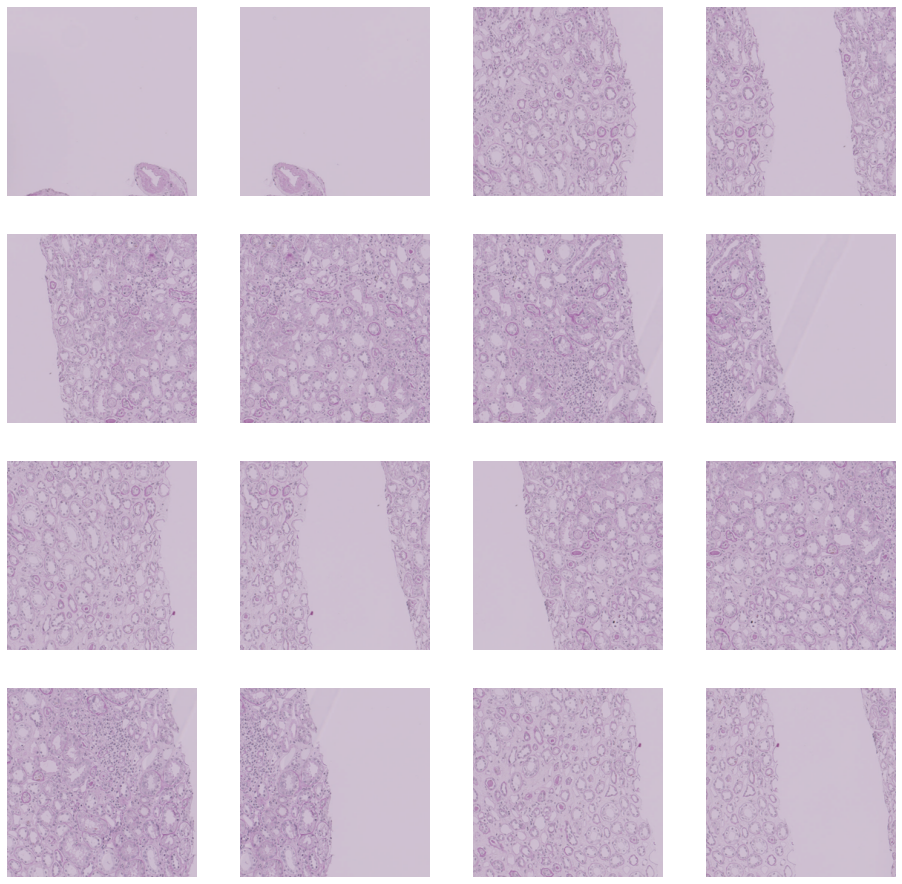

In [18]:
glom_lst = sorted(glob('../patches/tiles_r8_s256/*no.png'))
mask_lst = sorted(glob('../patches/masks_r8_s256/*no.png'))
columns, rows = 4,4
idx0 = 0
fig=plt.figure(figsize=(columns*4, rows*4))
for i in range(rows):
    for j in range(columns):
        idx = i+j*columns
        img = cv2.imread(glom_lst[idx0+idx], cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        mask = cv2.imread(mask_lst[idx0+idx], cv2.IMREAD_GRAYSCALE)

        fig.add_subplot(rows, columns, idx+1)
        plt.axis('off')
        plt.imshow(Image.fromarray(img))
        plt.imshow(Image.fromarray(mask), alpha=0.2)
plt.show()

In [ ]:
# img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
# h,s,v = cv2.split(hsv)
# print(s)
# plt.subplot(121)
# plt.imshow(img)
# plt.subplot(122)
# plt.imshow(img2)
# print(np.sum(s > 30))